# Assignment 3 - Michela Sessi 777760

## Classificazione basata sull'estrazione di feature neurali

In [54]:
import os
from matplotlib import pyplot as plt
from time import time
from skimage import feature
from keras.preprocessing import image as kimage
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
from keras.applications import DenseNet121
from keras.layers import Input

from keras.applications.resnet50 import preprocess_input
from keras.applications.xception import preprocess_input 

Carico la rete neurale DenseNet121 togliendo gli strati fully connected con pooling= "max".

In [12]:
net = DenseNet121(include_top=False, weights='imagenet', pooling='max', input_tensor=Input(shape=(224, 224, 3)))

29089792/29084464 [==============================] - 7s 0us/step


La funzione load_data permette di caricare le immagini relative a diverse cartelle. Attraverso la funzione net_features le features estratte sono quelle tramite la rete DenseNet121. 
Otteniamo quattro oggetti poichè splittati in training and test.

In [23]:
def load_data(feature_extractor, directory, maximages=-1, ext='.jpg'):
    base_path = './'+directory+'/'
    labels = []
    features = []
    for di,d in enumerate(sorted(os.listdir(base_path))):
        for fi,f in enumerate(sorted(os.listdir(base_path + d + '/'))):
            if f.endswith(ext) and (fi<maximages or maximages==-1):
                image = kimage.load_img(base_path + d + '/' + f, target_size=(224, 224))
                cur_features = feature_extractor(image)
                
                features.append(cur_features)
                labels.append(di)
        print("Caricate " + str(fi+1) + " immagini dalla cartella numero " + str(di) + " (" + d + ")")
        fi = -1
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, shuffle=True, random_state=1)
    return X_train, X_test, y_train, y_test


In [46]:
def net_features(img):
    x = kimage.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = densenet.preprocess_input(x)
    f = net.predict(x)
    return f.flatten()

### TASK 1: Cani vs Gatti

Carichiamo le 500 immagini di cani e le 500 immagini di gatti.

In [47]:
t0 = time()
X_train, X_test, y_train, y_test=load_data(feature_extractor=net_features, directory="Esercitazioni_04_notebook/Esercitazioni_04/classes")
print("Caricamento in  %0.3f secondi" %(time() - t0))

Caricate 500 immagini dalla cartella numero 0 (cat500)
Caricate 500 immagini dalla cartella numero 1 (dog500)
Caricamento in  573.016 secondi


In [48]:
X_train[6].shape

(1024,)

Ad ogni immagine sono associate 1024 features. 
Procediamo quindi a normalizzare.

In [50]:
X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

Viene allenata una SVM al fine di ottenere la migliore combinazione di parametri.

In [55]:
param_grid = {'C': [ 0.5, 1, 1.5, 2],
          'gamma': [ 0.0001, 0.001, 0.01], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

t2 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t2))

print("Migliore combinazione di parametri:")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

Addestramento completato in 17.554s
Migliore combinazione di parametri:
 C: 1
 gamma: 0.001


A seguire i risultati sul test con matrice di confusione e accuracy.

In [56]:
y_pred = clf.predict(X_test)

print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Report di classificazione:
             precision    recall  f1-score   support

          0       1.00      0.95      0.97       199
          1       0.95      1.00      0.98       201

avg / total       0.98      0.97      0.97       400



In [57]:
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("Accuratezza media= " + str(accuracy_score(y_test, y_pred)))

Matrice di confusione:
[[189  10]
 [  0 201]]
Accuratezza media= 0.975


Otteniamo dei valori nettamente più elevati. 
In particolare otteniamo una accuracy del 97.5% rispetto al 70.75% ottenuta con l'estrazione delle features tramite LBP.

### TASK 2: Flowers

Carichiamo un secondo dataset relativo a 5 categorie di fiori e procediamo allo stesso modo.
Il dataset è scaricabile al seguente link https://www.kaggle.com/alxmamaev/flowers-recognition

In [58]:
t0 = time()
X_train, X_test, y_train, y_test=load_data(feature_extractor=net_features, directory="flowers/flowers", ext='.jpg')
print("Caricamento in  %0.3f secondi" %(time() - t0))


Caricate 769 immagini dalla cartella numero 0 (daisy)
Caricate 1055 immagini dalla cartella numero 1 (dandelion)
Caricate 784 immagini dalla cartella numero 2 (rose)
Caricate 734 immagini dalla cartella numero 3 (sunflower)
Caricate 984 immagini dalla cartella numero 4 (tulip)
Caricamento in  2464.035 secondi


In [59]:
X_train_stack = np.array([])
for t in X_train:
    X_train_stack = np.concatenate((X_train_stack, t))
eps = 0.001
X_train_mean = X_train_stack.mean()
X_train_std = X_train_stack.std()
X_train = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_train]
X_test = [(t - X_train_mean + eps)/(X_train_std + eps) for t in X_test]

Alleniamo la SVM inizialmente con valori più vari per i parametri e poi (come riportato) intorno ai valori rilevati.

In [67]:
param_grid = {'C': [ 5, 7, 8, 9, 10 ],
          'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1 ], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, n_jobs=-1)

t2 = time()
clf = clf.fit(X_train, y_train)
print("Addestramento completato in %0.3fs" % (time() - t2))

print("Migliore combinazione di parametri:")
print(" C: "+str(clf.best_estimator_.C))
print(" gamma: "+str(clf.best_estimator_.gamma))

Addestramento completato in 68.912s
Migliore combinazione di parametri:
 C: 8
 gamma: 0.001


Ottenuti parametri ottimali di C=8 e gamma=0.001 otteniamo il seguente report di classificazione, la matrice di confusione e l'accuracy pari a 0.899.

In [68]:
y_pred = clf.predict(X_test)

print("Report di classificazione:")
print(classification_report(y_test, y_pred))

Report di classificazione:
             precision    recall  f1-score   support

          0       0.92      0.89      0.90       312
          1       0.92      0.93      0.92       430
          2       0.85      0.87      0.86       296
          3       0.94      0.89      0.92       304
          4       0.87      0.90      0.89       388

avg / total       0.90      0.90      0.90      1730



Matrice di confusione:
[[277  18   5   4   8]
 [ 15 401   4   7   3]
 [  3   2 258   3  30]
 [  5  12   6 272   9]
 [  1   5  32   2 348]]


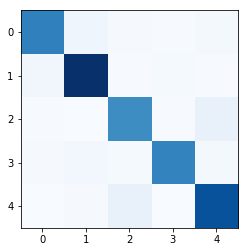

In [70]:
print("Matrice di confusione:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap='Blues'); plt.show()

In [79]:
print("Accuratezza media: " + str(round(accuracy_score(y_test, y_pred), 4)))

Accuratezza media: 0.8994
